## Number recognizer

This code is for the digit recognizer Kaggle competition
https://www.kaggle.com/c/digit-recognizer

Note: Use the following line for debugging in Jupyter

In [1]:
# from IPython.core.debugger import Tracer; Tracer()()

# Preprocessing (Run only once)

Metacode:
1. Convert each part of the grid into separate images
2. For each image, keep a log of what number it is (CSV). This is similar to the planet multiclassification.

Note: The training and test models are slightly different, so a new function is necessary (for this silly version 1)

## Import packages

In [14]:
import csv
import numpy as np
import png

## Definitions

In [44]:
# Read in the data from the training CSV file and convert to a png
def read_training(input_file):
    with open(input_file) as f:
        # Create a csv reader object.
        reader = csv.reader(f,delimiter=',')
        has_header = csv.Sniffer().has_header(f.read(1024))
        f.seek(0)  # rewind
        incsv = csv.reader(f)
        if has_header:
            next(incsv)  # skip header row
            
        # Write in the image number and result in a csv file
        # First we create it, so we delete any previous versions
        g = open(f'{output_dir}train_output.txt', 'w')
        g.write('id,num\n')
        
        # Store the latitudes and longitudes in the appropriate lists.
        for row in reader:
            
            # Come up with an image name based on the row number with trailing zeros
            image_number = "%05d" % (reader.line_num,)
            
            # Add the image name and the representative number of the image to the csv file
            g.write('{0},{1}\n'.format(f'image_{image_number}', row[0]))
            
            # Remove the first number and shape the list into a 2D Numpy array
            row.pop(0)
            pixel_2d_array = np.array(row).reshape(28,28)
            
            # Save the pixel array as a jpg
            f = open(f'{train_image_output}image_{image_number}.png', 'wb')      # binary mode is important
            w = png.Writer(28, 28, greyscale=True)
            w.write(f, pixel_2d_array)
            f.close()
    
#             from IPython.core.debugger import Tracer; Tracer()() 
            
    return
        

In [21]:
# Read in the data from the test CSV file and convert to a png
def read_test(input_file):
    with open(input_file) as f:
        # Create a csv reader object.
        reader = csv.reader(f,delimiter=',')
        has_header = csv.Sniffer().has_header(f.read(1024))
        f.seek(0)  # rewind
        incsv = csv.reader(f)
        if has_header:
            next(incsv)  # skip header row
        
        # Store the latitudes and longitudes in the appropriate lists.
        for row in reader:
            
            # Come up with an image name based on the row number with trailing zeros
            image_number = "%05d" % (reader.line_num,)
                        
            # Shape the list into a 2D Numpy array
            pixel_2d_array = np.array(row).reshape(28,28)
            
            # Save the pixel array as a jpg
            f = open(f'{test_image_output}image_{image_number}.png', 'wb')      # binary mode is important
            w = png.Writer(28, 28, greyscale=True)
            w.write(f, pixel_2d_array)
            f.close()
    
#             from IPython.core.debugger import Tracer; Tracer()() 
            
    return
        

## Main

In [45]:
trainfile = '/home/paperspace/kaggle_projects/digit_recognizer/train.csv'
testfile = '/home/paperspace/kaggle_projects/digit_recognizer/test.csv'
output_dir = '/home/paperspace/kaggle_projects/digit_recognizer/output/'
train_image_output = '/home/paperspace/kaggle_projects/digit_recognizer/output/train_images/'
test_image_output = '/home/paperspace/kaggle_projects/digit_recognizer/output/test_images/'

In [46]:
# Read the training data and convert to png
read_training(trainfile)

In [25]:
# Read the test data and convert to png
read_test(testfile)

The data is now preprocessed and converted to png images.

# Create a model using the training data

## Import Packages

In [4]:
import sys
sys.path.append('/home/paperspace/fastai')
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Setup definitions

In [5]:
# # Only return data if it is greater than a certain size
# def get_data(sz,bs):
#     tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#     data = ImageClassifierData.from_csv(output_directory, 'train_images', label_csv, test_name='test_images', 
#                                     val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)
    
#     return data if sz>300 else data.resize(340,'tmp')

In [6]:
#ImageClassifierData.from_csv??

## Main

In [7]:
#torch.cuda.set_device(1)
input_directory = '/home/paperspace/kaggle_projects/digit_recognizer/output/train_images/'
output_directory = '/home/paperspace/kaggle_projects/digit_recognizer/output/'
label_csv = '/home/paperspace/kaggle_projects/digit_recognizer/output/train_output.txt' 

In [8]:
# sz is the size that images will be resized to
sz = 224

# arch is the pre-trained model that we will be using in this instance
#arch=resnext101_64 # This may be broken
arch=resnet34

# bs is batch size
bs=58

# Find the total number of entries in the label file and take a random sampling (20%) for the validation set
n = len(list(open(label_csv)))-1
val_idxs=get_cv_idxs(n)

In [9]:
# Read the labels file using Pandas
label_df = pd.read_csv(label_csv)

label_df.head()

,id,num
0,image_00001,1
1,image_00002,0
2,image_00003,1
3,image_00004,4
4,image_00005,0


In [10]:
# Organizes the data by classification and lists the sizes in descending order
label_df.pivot_table(index='num', aggfunc=len).sort_values('id', ascending=False)

,id
num,
1,4684
7,4401
3,4351
9,4188
2,4177
6,4137
0,4132
4,4072
8,4063


In [11]:
# Let's print out pictures of of the numbers to double check
num_ind = np.where(np.array(label_df.num)==7); num_ind[0]

array([    6,    18,    29, ..., 41980, 41983, 41997])

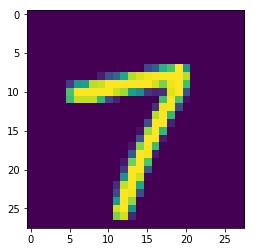

In [12]:
img = plt.imread(output_directory+'train_images/'+label_df.id[np.random.choice(num_ind[0])]+'.png')
plt.imshow(img)

In [13]:
# Describe the augmentation that we want to do
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [14]:
data = ImageClassifierData.from_csv(output_directory, 'train_images', label_csv, test_name='test_images', 
                                    val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)

Trial number 1

# Step 1 - Enable data augmentation and set precompute = true
This is a pretrained model (described by the variable arch), meaning we are testing a previously developed model that has been used to solve a different problem.
The model has several layers, going from basic shapes (lines and curves) to whatever we are inputting in the model to test (in our example it's an image of a cat or a dog). Setting pre-compute = False means that we want to recompute every layer based on our input model data, i.e. it looks at an image of a cat or a dog and then tries to get out lines and curve information from the input data. By setting precompute = True, we say that only the last (most complicated) layer should be edited. The data shouldn't affect the model's conception of basic shapes. 
Note: When precompute = True, data augmentation will not be possible. However, we will enable data augmentation in Step 4.  
Note 2: If we choose to use precompute=False and retrain the basic layers, we will get into serious trouble if we don't have enough data for it to understand the basic shapes.  

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

# Step 2 - Use lr_find() 
This is used to find the highest learning rate where the loss is still clearly improving.

In [11]:
lrf=learn.lr_find()

 80%|████████  | 465/580 [00:06<00:01, 74.74it/s, loss=2.65] 


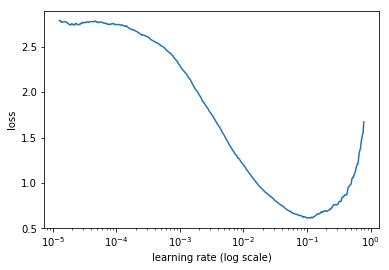

In [12]:
learn.sched.plot()

# Step 3 - Train the last layer from pre-computed activations
Takes the Python class of the model created in Step 1 (learn) and fits a specific learning rate (1e-2). In Step 1, we set precompute = True, which means we can only affect the last layer. This is why we only input one learning rate. The second number is the epoch, or the number of times that the last layer should be trained. A third number is sometimes added, and is the cycle length, or how many epochs in a cycle. 

In [16]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.351285   0.186998   0.945119  
    1      0.284928   0.163515   0.952619                    
    2      0.26355    0.148964   0.956548                    



[array([0.14896]), 0.9565476202255203]

In [15]:
learn.fit(1e-1, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.316784   0.144671   0.953095  
    1      0.234718   0.137058   0.961429                    
    2      0.25796    0.13283    0.96381                     



[array([0.13283]), 0.9638095245616777]

# Step 4 - Train the last layer again but with data augmentation
As mentioned before, precompute = True makes the training unable to use data augmentation. Unlike what I used to think, precompute=False isn't enough to train the initial layers on the model. To train the basic layers, we need to set precompute=False AND unfreeze the layers. However, when we just set precompute = False, we can now use data augmentation and rerun the model to see how the last layer reacts to data augmentation. 
Note: This step is a lot slower than it should be due to using resnet34 architecture instead of resnext50. Unfortunately, resnext50 architecture seems broken in the current fastai environment. 

In [16]:
learn.precompute=False

In [17]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.628306   0.176976   0.946548  
    1      0.535411   0.189767   0.942738                    



[array([0.18977]), 0.9427380980480284]

It makes sense that the accuracy is worse with data augmentation. Certain numbers will be confused (6 and 9, 1 and 7)

# Step 5 - Unfreeze all layers
This is the second component to allow the data to train even the most fundamental parts of the model.  

In [12]:
learn.unfreeze()

# Step 6 - Set earlier layers to 3 to 10 times lower learning rate than the next highest layer.
Although it's obvious that the last element in the array is the learning rate for the last layers, the first two numbers confused me. It's NOT the two layers prior to the last layer. Instead, the first number represents the learning rate for a grouping of the most basic layers and the second number is the learning rate for a grouping of the intermediate layers. 
Note: Just as a reminder, this is just using the numpy library (imported as np) to create an array. The application of this parameter is actually in Step 8. 

In [13]:
lr=np.array([1e-4,1e-3,1e-2])

# Step 7 - Use lr_find() to use the optimal learning rate. 
This is very strange for me, as we already set the learning rate in Step 6. It's difficult to say because he doesn't use lr_find() in this example. 

# Step 8 - Rerun the fit after unfreezing all of the layers and setting the learning rates. 


In [14]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.605031   0.403188   0.877857  
    1      0.54549    0.337103   0.898333                    
    2      0.503141   0.324424   0.898214                    



[array([0.32442]), 0.8982142909793627]

In [15]:
learn.save('224_test')

In [16]:
learn.load('224_test')
# learn.load('/home/paperspace/kaggle_projects/digit_recognizer/output/models/224_test')

In [31]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)

In [32]:
probs

array([[0.00012, 0.00012, 0.00001, ..., 0.97652, 0.00002, 0.02163],
       [0.00022, 0.00001, 0.01279, ..., 0.00015, 0.66487, 0.01118],
       [0.     , 0.00021, 0.00001, ..., 0.00185, 0.00003, 0.00007],
       ...,
       [0.00002, 0.00027, 0.00001, ..., 0.98012, 0.00001, 0.00945],
       [0.00001, 0.99965, 0.     , ..., 0.00002, 0.     , 0.     ],
       [0.00312, 0.00008, 0.06067, ..., 0.00018, 0.90856, 0.0157 ]], dtype=float32)

In [42]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [43]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [44]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [50]:
df.sort_values(by=['id'])

,id,0,1,2,3,4,5,6,7,8,9
25899,images/image_00001,2.691638e-05,9.692266e-07,9.993126e-01,3.060399e-04,1.277185e-05,1.077775e-04,1.881185e-05,8.126686e-05,1.242199e-04,8.420839e-06
24075,images/image_00002,9.935389e-01,3.356904e-06,1.556437e-03,1.221404e-03,1.338354e-05,1.653342e-03,5.518065e-04,1.964072e-04,4.059412e-04,8.592283e-04
27041,images/image_00003,1.166208e-04,2.418933e-04,2.656803e-02,9.555443e-04,1.733194e-03,7.310199e-05,1.077047e-04,4.176316e-03,2.642923e-03,9.633847e-01
14035,images/image_00004,1.694572e-01,6.037720e-04,9.850350e-02,6.406011e-02,1.285445e-02,3.484404e-02,5.497239e-02,1.290488e-01,2.022146e-02,4.154344e-01
4611,images/image_00005,1.442330e-05,5.753614e-06,1.625855e-01,8.125688e-01,2.674334e-06,4.290963e-04,1.641985e-04,1.415647e-05,2.411388e-02,1.016037e-04
521,images/image_00006,1.155822e-05,3.928296e-06,5.397513e-04,4.625386e-04,4.450369e-05,1.786039e-03,2.366603e-06,9.948862e-01,6.598781e-05,2.197054e-03
18897,images/image_00007,9.987077e-01,6.984700e-07,3.262000e-04,1.289613e-04,8.057981e-06,4.880899e-05,1.244171e-04,8.627056e-06,5.481416e-04,9.826887e-05
16044,images/image_00008,2.407836e-05,5.075082e-06,1.924582e-02,9.784648e-01,1.208425e-05,1.995992e-03,2.306931e-06,1.458786e-04,3.962557e-05,6.410377e-05
12,images/image_00009,9.999590e-01,9.276563e-08,6.466858e-06,1.598961e-06,5.103801e-08,8.402802e-07,2.368463e-05,8.774686e-08,3.318368e-06,4.792978e-06
11293,images/image_00010,6.509584e-08,1.514222e-06,1.003798e-03,9.951102e-01,2.245174e-07,3.862418e-03,3.780420e-07,1.857035e-06,1.552560e-05,4.286043e-06


In [48]:
df.head()

,id,0,1,2,3,4,5,6,7,8,9
0,images/image_12008,1.201619e-04,1.195011e-04,0.000014,0.000059,0.001522,0.000002,0.000002,0.976517,0.000018,0.021625
1,images/image_16578,2.170098e-04,9.112447e-06,0.012794,0.028274,0.000660,0.199208,0.082642,0.000149,0.664870,0.011178
2,images/image_15071,4.039267e-07,2.135690e-04,0.000007,0.000001,0.997701,0.000113,0.000015,0.001851,0.000026,0.000070
3,images/image_26364,7.658276e-05,1.945283e-05,0.989985,0.007990,0.000025,0.001293,0.000391,0.000129,0.000053,0.000038
4,images/image_16576,9.408084e-06,7.616359e-07,0.980246,0.000083,0.000152,0.000003,0.000018,0.000003,0.019422,0.000063


In [51]:
final_array = np.array(df)

In [56]:
r,c = final_array.shape

In [105]:
def create_submission(input_array):
    image_index, predicted_number = [], []
    for row_index in np.arange(r):
        image_name = final_array[row_index,0]
        image_index.append(int(image_name[13:18]))
        
        predicted_number.append(np.where(final_array[row_index,1:] == np.max(final_array[row_index,1:]))[0][0])
                
    
    return image_index, predicted_number


In [106]:
index, value = create_submission(final_array)

In [109]:
combined_values = np.c_[index,value]

In [115]:
combined_values

array([[12008,     7],
       [16578,     8],
       [15071,     4],
       ...,
       [  105,     7],
       [  758,     1],
       [ 5688,     8]])

In [116]:
combined_values = combined_values[combined_values[:,0].argsort()]

In [117]:
np.savetxt(output_directory+'submission.csv', combined_values,header='ImageId,Label',delimiter=",", fmt="%s")